<a href="https://colab.research.google.com/github/liuxx479/NGphotoz/blob/master/prep_mass_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from pylab import *
from scipy.stats import norm
from scipy.stats import uniform
from astropy.io import fits
from astropy import units as u
import os
sys.modules["mpi4py"] = None
from lenstools import ConvergenceMap
%matplotlib inline

In [3]:
######### goals of this notebook
## 1) compute the nubmer density per redshift bin, using the fiducial photo-z (check if used a gaussian window or step functions)
## 2) add noise as GRF to each redshift
## 3) define the bin edges
## 4) smooth the maps
## 5) compute peaks, minima, PDF, MFs, moments
## 6) turn this into a python code

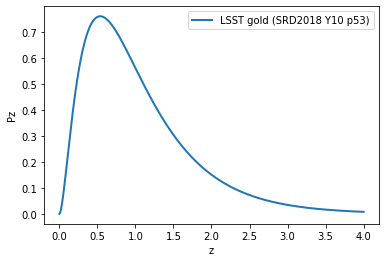

In [13]:
##### number density per redshift bins
def Pz_norm(zp_support, pz):
  return pz/np.trapz(pz, zp_support)

def Pz_norm_tomo(zp_support, pz):
  return array([Pz_norm(zp_support, ipz) for ipz in pz])

zarr=np.linspace(0,4, 501)
delta_z=0.5

tomo_centers=np.arange(0.5, 3, delta_z)
tomo_widths=np.ones(5)*delta_z
tomo_edges = np.array([tomo_centers-delta_z/2, tomo_centers+delta_z/2]).T

z0_SRD, alpha_SRD = 0.11, 0.68
Pz_SRD_unnorm = lambda z: z**2 * exp(-(z/z0_SRD)**alpha_SRD)
Pz_SRD_norm = lambda z: Pz_norm(z, Pz_SRD_unnorm(z))

plot(zarr, Pz_SRD_norm(zarr), lw=2, label='LSST gold (SRD2018 Y10 p53)')
xlabel('z')
ylabel('Pz')
legend()
show()

In [29]:
############ fiducial model: pz_true.txt (edited) 
### zbias=0, sigma_z=0, outlier=0; it should have sharp cut off at the bin edges ([0.25, 0.75], [0.75, 1.25]...)
####### LSST SRD Y10 numbers page 53
######## SRD: https://arxiv.org/abs/1809.01669
## neff: (z0, α) = (0.13, 0.78) for Y1 and (0.11, 0.68) for Y10
## neff = 10 and 27 arcmin−2 as the lensing neff in Y1 and Y10
## however, according to the original Chang 2013 paper, unmasked neff=37
sigma_e = 0.26 ## per component, do I need a sqrt(2) to get both components? (I didn't do this in 2014..)
neff = 37 ## chang+2013 n=46, for fiducial case
ngal = 46

In [30]:
ngal_tomo = np.zeros(5)
Pz_norm_factor = np.trapz(Pz_SRD_unnorm(zarr),zarr)
print (Pz_norm_factor)

for i in range(5):
    iz0,iz1=tomo_edges[i]
    izarr=zarr[where((zarr>iz0)&(zarr<iz1))]
    ngal_tomo[i]= ngal * np.trapz(Pz_SRD_unnorm(izarr), izarr) / Pz_norm_factor

0.020049679068572506


In [45]:
print ('number of galaxies per redshift bin \n(ngal=%i, %s galaxies in 5 bins):'%(ngal, sum(ngal_tomo)))
for i in range(5):
    print ('z=%s, ngal=%.2f'%(tomo_edges[i], ngal_tomo[i]))

number of galaxies per redshift bin 
(ngal=46, 40.99631314209885 galaxies in 5 bins):
z=[0.25 0.75], ngal=16.07
z=[0.75 1.25], ngal=12.82
z=[1.25 1.75], ngal=6.93
z=[1.75 2.25], ngal=3.51
z=[2.25 2.75], ngal=1.66


In [73]:
########## Add galaxy noise
test_dir = '/global/cscratch1/sd/jialiu/desc-sprint-raytracing/Cosmo_maps/06_f/'
os.listdir(test_dir)[:10]
fnames = [test_dir+'kappa_LSST-SRD_tomo%i_cone5.fits'%(i) for i in range(1,6)]
test_maps = array([fits.open(ifn)[0].data for ifn in fnames])
istds = [std(it) for it in test_maps]
print (istds)

[0.007314169, 0.019146424, 0.031151935, 0.041499652, 0.050280314]


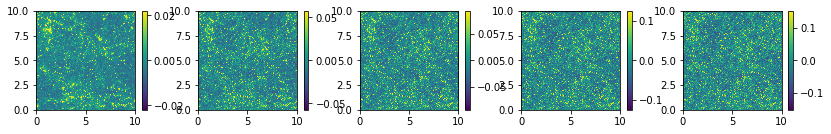

In [74]:
figure(figsize=(14,4))
for i in range(5):
    subplot(2,5,i+1)
    istd=istds[i]
    imshow(test_maps[i], vmin=-3*istd, vmax=3*istd, origin='lower', extent=[0,10,0,10])
    colorbar()

In [75]:
#Compute shape noise amplitude
conv_maps = [ConvergenceMap(data=imap, angle=10*u.degree) for imap in test_maps]

In [ ]:
pixel_angular_side = conv_maps[0].side_angle / conv_maps[0].data.shape[0]

sigma_pix_arr =[ (sigma_e / (pixel_angular_side * sqrt(ingal / u.arcmin**2))).decompose().value
                for ingal in ngal_tomo]

print (conv_maps[0].side_angle, conv_maps[0].data.shape[0])
print (pixel_angular_side.to (u.arcmin))
print (sigma_pix_arr)

np.random.seed(2)
noise_maps = [np.random.normal(loc=0.0, scale=sigma_pix_arr[i], size=conv_maps[0].data.shape) 
              for i in range(5)]

# #Generate shape noise
#sigma = ((0.15 + 0.035*z) / (pixel_angular_side * np.sqrt(ngal))).decompose().value
# np.random.seed(seed)
# noise_map = np.random.normal(loc=0.0,scale=sigma,size=self.shape) 

In [ ]:
conv_noisy_maps = [ test_maps[i]+noise_maps[i] for i in range(5)]

In [46]:
!git add prep_mass_production.ipynb; 
!git commit -m 'update prep_mass_production.ipynb; add ngal calculation'
!git push

[master 7cdc293] update prep_mass_production.ipynb; add ngal calculation
 1 file changed, 40 insertions(+), 3 deletions(-)
Counting objects: 3, done.
Delta compression using up to 64 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 946 bytes | 946.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To ssh://github.com/liuxx479/NGphotoz.git
   1fca764..7cdc293  master -> master
